In [1]:
import os
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from sklearn.model_selection import train_test_split
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=42)  

df = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
df

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.O=C(O)C1CCCN1C(=O)OCc1ccccc1,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,93.0,23.0
1,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCCCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,82.0,23.0
2,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)N1CCOCC1C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,61.0,23.0
3,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)C(NC(=O)OC(C)(C)C)C(=O)O,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,72.0,23.0
4,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,CC(=O)c1ccc(Br)cc1.CC(C)(C)OC(=O)NC(Cc1cn(C(=O...,O=C([O-])[O-].[Cs+],CN(C)C=O,NaN,NaN,CC(=O)c1ccc(C2CCCN2C(=O)OCc2ccccc2)cc1,83.0,23.0
...,...,...,...,...,...,...,...,...,...
2268539,NaN,CN1CCCC1=O.COc1cc(C(=O)CO)ccc1OCCCCl.Fc1ccc2c(...,NaN,O,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,100.0
2268540,NaN,CC(O)=S.CCOC(=O)N=NC(=O)OCC.O=C1C[C@@H](O)CN1....,NaN,C1CCOC1,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268541,NaN,C[C@@H](O[Si](C)(C)C(C)(C)C)[C@H]1C(=O)N2C(C(=...,NaN,CC#N,NaN,NaN,CC(O)CC(=O)[O-].O=C([O-])CCCO,NaN,NaN
2268542,CC(=O)[O-].O.[Cu+2],C=O.CC(=O)O.CC(=O)[O-].CCOC(=O)CC(=O)OCC.[K+],NaN,NaN,NaN,NaN,O=S(=O)(c1ccc(Cl)cc1)C(F)(F)F,NaN,NaN


In [128]:
df[~df['NoData'].isna()]

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
73855,NaN,NaN,NaN,NaN,NaN,C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1,NaN,NaN
73856,NaN,NaN,NaN,NaN,NaN,CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,CNc1ccc(C(=O)O)cc1[N+](=O)[O-],NaN,NaN
73857,NaN,NaN,NaN,NaN,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21,NaN,NaN
73858,NaN,NaN,NaN,NaN,NaN,CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...,NaN,NaN
73859,NaN,NaN,NaN,NaN,NaN,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2051384,NaN,NaN,NaN,NaN,NaN,CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl,CCOc1ccccc1OC1CN(CC)CC1O,NaN,NaN
2051385,NaN,NaN,NaN,NaN,NaN,CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...,CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC,NaN,NaN
2051386,NaN,NaN,NaN,NaN,NaN,CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...,CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1,NaN,NaN
2051387,NaN,NaN,NaN,NaN,NaN,CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....,COC(=O)c1cc(Br)cc2c1ccn2C(C)C,NaN,NaN


In [129]:
dic = {col:i for i, col in enumerate(df.columns[:-3])}
lis = []
for key in dic.keys():
    for vals in df[key].values:
        if type(vals) == str:
            for val in vals.split('.'):
                lis.append([val, dic[key]])

        

In [130]:
df[~df['NoData'].isna()]

,CATALYST,REACTANT,REAGENT,SOLVENT,INTERNAL_STANDARD,NoData,PRODUCT,YIELD,TEMP
73855,NaN,NaN,NaN,NaN,NaN,C1CCOC1.CC(C)C[Mg+].CON(C)C(=O)c1ccc(O)nc1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1,NaN,NaN
73856,NaN,NaN,NaN,NaN,NaN,CN.O.O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,CNc1ccc(C(=O)O)cc1[N+](=O)[O-],NaN,NaN
73857,NaN,NaN,NaN,NaN,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21....,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21,NaN,NaN
73858,NaN,NaN,NaN,NaN,NaN,CC(C)=C(Cl)N(C)C.COCC(C)Oc1cc(Oc2cnc(C(=O)N3CC...,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...,NaN,NaN
73859,NaN,NaN,NaN,NaN,NaN,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1.NCc1ccc(Cl)c(Cl)c1,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2051384,NaN,NaN,NaN,NaN,NaN,CCN1CC2OC2C1.CCOc1ccccc1O.Cl.ClCCl,CCOc1ccccc1OC1CN(CC)CC1O,NaN,NaN
2051385,NaN,NaN,NaN,NaN,NaN,CC(=O)O.CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=...,CCOC(=O)C(Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1)OCC,NaN,NaN
2051386,NaN,NaN,NaN,NaN,NaN,CCCCC1CCNCC1.Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3...,CCCCC1CCN(CC(C)Cn2c(=O)sc3ccccc32)CC1,NaN,NaN
2051387,NaN,NaN,NaN,NaN,NaN,CC(C)I.CN(C)C=O.COC(=O)c1cc(Br)cc2[nH]ccc12.O....,COC(=O)c1cc(Br)cc2c1ccn2C(C)C,NaN,NaN


In [131]:
df['NoData'].values[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [132]:
dic

{'CATALYST': 0,
 'REACTANT': 1,
 'REAGENT': 2,
 'SOLVENT': 3,
 'INTERNAL_STANDARD': 4,
 'NoData': 5}

In [133]:
df = pd.DataFrame(lis, columns=['smiles', 'target'])
df

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
10816419,[H-],5
10816420,[Na+],5
10816421,CC(C)(C)OC(=O)N1CCCC1CO,5
10816422,CCN(CC)CC,5


In [134]:
df['target'].value_counts()

1    6155626
5    2290925
3    1912075
0     419830
2      30099
4       7869
Name: target, dtype: int64

In [181]:
# ori = pd.read_csv('../../all_ord_reaction_uniq_with_attr_v3.tsv')
# for idx, row in ori.iterrows():
#     rea = row['REACTANT']
#     if type(rea) == str and '[Cu]I' in rea:
#         break
# print(row)

CATALYST                                                           NaN
REACTANT             C#CCOCCNC(=O)C(F)(F)F.CC(C)(C)[Si](C)(C)OOC[C@...
REAGENT                                                            NaN
SOLVENT                                                            NaN
INTERNAL_STANDARD                                                  NaN
NoData                                                             NaN
PRODUCT                                 c1ccc2sc(-c3nccc4ccccc34)cc2c1
YIELD                                                              NaN
TEMP                                                               NaN
Name: 747458, dtype: object


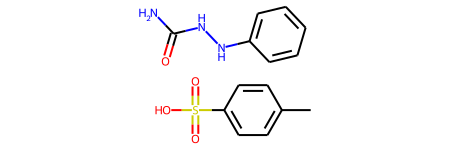

In [190]:
from rdkit import Chem
row = ori.iloc[10000]
Chem.MolFromSmiles(row['REACTANT'])

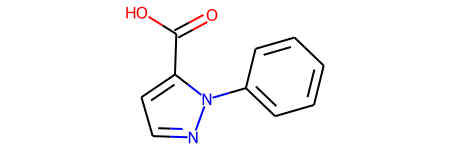

In [191]:
Chem.MolFromSmiles(row['PRODUCT'])

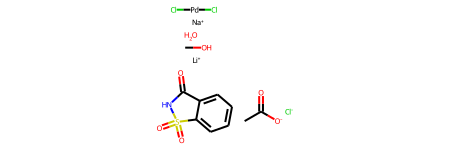

In [175]:
Chem.MolFromSmiles(row['NoData'])

In [52]:
df = df.drop_duplicates()
df

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
10816367,CCOC(=O)c1cccc2nc(CCl)n(Cc3ccc(-c4ccccc4-c4nnn...,5
10816374,COc1cccc2c1OC(CO)C2,5
10816396,CC(CCCl)C(=O)Nc1cc(C(C)(C)C)ns1,5
10816408,CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...,5


In [24]:
# df.to_csv('../../all_data_for_classification.csv', index=False)
df = pd.read_csv('../../all_data_for_classification.csv')
df = df[(df['target']!=4)&(df['target']!=5)]
df['target'].value_counts()

1    678763
0      1959
3      1576
2        82
Name: target, dtype: int64

In [18]:
df[df['target'] != 1]

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
682375,O=P(=O)O,3
682376,O=P(=O)[O-],3
682377,CC(O)COC(C)CO,3
682378,BrC(Br)Br,3


In [25]:
lis = []
for idx, row in df.iterrows():
    if row['target'] != 1:
        lis.append(0)
    else:
        lis.append(1)
df['target'] = lis
df['target'].value_counts()

1    678763
0      3617
Name: target, dtype: int64

In [21]:
df.drop_duplicates()['target'].value_counts()

1    678763
0      3119
Name: target, dtype: int64

In [26]:
df = df.drop_duplicates().reset_index(drop=True)

In [27]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
df['fold'] = -1
for fold, (tr_idx, va_idx) in enumerate(skf.split(df['smiles'], df['target'])):
    df['fold'][va_idx] = fold
df

,smiles,target,fold
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0,0
2,COCCOC,0,0
3,Cl[Ni]Cl,0,0
4,F[P-](F)(F)(F)(F)F,0,0
...,...,...,...
681877,FCF,0,9
681878,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,0,9
681879,O=P(=O)O,0,9
681880,CC(O)COC(C)CO,0,9


In [28]:
df['fold'].value_counts()

0    68189
1    68189
2    68188
3    68188
4    68188
5    68188
6    68188
7    68188
8    68188
9    68188
Name: fold, dtype: int64

In [29]:
df.to_csv('../../data_for_classification_binary.csv', index=False)

In [2]:
df = pd.read_csv('../../data_for_classification.csv')
df

,smiles,target,fold
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0,0
2,COCCOC,0,0
3,Cl[Ni]Cl,0,0
4,F[P-](F)(F)(F)(F)F,0,0
...,...,...,...
682377,CC(O)COC(C)CO,3,9
682378,BrC(Br)Br,3,9
682379,C1CN=C2CCCN2C1,3,9
682380,CC(C)(C)c1ccc(-c2ccc(C(C)(C)C)cc2)cc1,4,0


In [4]:
df['target'].value_counts()

1    678763
0      1959
3      1576
2        82
4         2
Name: target, dtype: int64

In [59]:
df[df['fold'] == 0].drop(['fold'], axis=1)

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
680957,CCCCCCO,3
680958,ClCC(Cl)Cl,3
680959,CCN,3
680960,CCCCOCCCC,3


In [61]:
df['len'] = df['smiles'].apply(lambda x: len(x))
df

,smiles,target,fold,len
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0,0,124
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0,0,37
2,COCCOC,0,0,6
3,Cl[Ni]Cl,0,0,8
4,F[P-](F)(F)(F)(F)F,0,0,18
...,...,...,...,...
682377,CC(O)COC(C)CO,3,9,13
682378,BrC(Br)Br,3,9,9
682379,C1CN=C2CCCN2C1,3,9,14
682380,CC(C)(C)c1ccc(-c2ccc(C(C)(C)C)cc2)cc1,4,0,37


In [66]:
df[['len']].describe()

,len
count,682382.000000
mean,40.713246
std,20.079330
min,1.000000
25%,27.000000
50%,37.000000
75%,51.000000
max,902.000000


In [73]:
df['len'].quantile(0.9999)

279.04759999969974

In [74]:
!nvidia-smi

Sun Oct 30 11:45:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:19:00.0 Off |                  N/A |
| 31%   34C    P8     2W / 250W |      4MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:1A:00.0 Off |                  N/A |
| 55%   

In [37]:
import os
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel, T5EncoderModel, get_linear_schedule_with_warmup
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW
import pickle
import time
import math
from sklearn.preprocessing import MinMaxScaler
from datasets.utils.logging import disable_progress_bar
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
disable_progress_bar()


class CFG():
    data_path='../../classification-input-valid.csv'
#     pretrained_model_name_or_path = 'sagawa/ZINC-t5'
    pretrained_model_name_or_path='sagawa/ZINC-t5'
    debug = True
    epochs = 5
    lr = 2e-5
    batch_size = 15 #max_lenを大きくしたらoomしたから15から5に
    max_len = 128
    weight_decay = 0.01
    seed = 42
    num_workers = 4
    fc_dropout = 0.1
    eps = 1e-6
    max_grad_norm=1000
    gradient_accumulation_steps=1
    num_warmup_steps=0
    batch_scheduler=True
    print_freq=100
    use_apex=False
    output_dir = './'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

OUTPUT_DIR = CFG.output_dir
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=CFG.seed)  
    

df = pd.read_csv(CFG.data_path)



def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

#load tokenizer
try: # load pretrained tokenizer from local directory
    tokenizer = AutoTokenizer.from_pretrained(os.path.abspath(CFG.pretrained_model_name_or_path), return_tensors='pt')
except: # load pretrained tokenizer from huggingface model hub
    tokenizer = AutoTokenizer.from_pretrained(CFG.pretrained_model_name_or_path, return_tensors='pt')

CFG.tokenizer = tokenizer
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text, add_special_tokens=True, max_length=CFG.max_len, padding='max_length', return_offsets_mapping=False, truncation=True, return_attention_mask=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    
    return inputs

    
class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['smiles'].values
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        
        return inputs
    
       
class RegressionModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.pretrained_model_name_or_path, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            if 't5' in cfg.pretrained_model_name_or_path:
                self.model = T5EncoderModel.from_pretrained(CFG.pretrained_model_name_or_path)
            else:
                self.model = AutoModel.from_pretrained(CFG.pretrained_model_name_or_path)
        else:
            if 't5' in cfg.model_name_or_path:
                self.model = T5EncoderModel.from_pretrained('sagawa/ZINC-t5')
            else:
                self.model = AutoModel.from_config(self.config)
        self.model.resize_token_embeddings(len(cfg.tokenizer))
        self.fc_dropout1 = nn.Dropout(cfg.fc_dropout)
        self.fc1 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.fc_dropout2 = nn.Dropout(cfg.fc_dropout)
        self.fc2 = nn.Linear(self.config.hidden_size, 2)
        
    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        output = self.fc1(self.fc_dropout1(last_hidden_states)[:, 0, :].view(-1, self.config.hidden_size))
        output = self.fc2(self.fc_dropout2(output))
        output = F.softmax(output, dim=1)
        return output

    
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions



 

In [47]:
CFG.model_name_or_path = 't5'
df = pd.read_csv(CFG.data_path)


# train_ds = df[df['fold'] != 0].drop(['fold'], axis=1)
valid_ds = df


# valid_ds = pd.read_csv('../../classification-input-valid.csv')
valid_dataset = TestDataset(CFG, valid_ds)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
model = RegressionModel(CFG, config_path='./config.pth', pretrained=False)
state = torch.load('./ZINC-t5_best.pth', map_location=torch.device('cpu'))
model.load_state_dict(state)


# model = RegressionModel(CFG, config_path=CFG.model_name_or_path + '/config.pth', pretrained=False)
# state = torch.load(CFG.model_name_or_path + '/ZINC-t5_best.pth', map_location=torch.device('cpu'))
# model.load_state_dict(state)

Some weights of the model checkpoint at sagawa/ZINC-t5 were not used when initializing T5EncoderModel: ['lm_head.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.10.layer.2.DenseReluDense.wo.weight', 'decoder.block.7.layer.2.DenseReluDense.wi_0.weight', 'decoder.final_layer_norm.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.2.layer.1.EncDecAttention.v.weight', 'decoder.block.3.layer.1.EncDecAttention.q.weight', 'decoder.block.11.layer.0.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.10.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.k.weight', 'decoder.block.7.layer.2.layer_norm.weight', 'decoder.embed_tokens.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.

<All keys matched successfully>

In [48]:
model.to(device)
preds = []
for inputs in valid_loader:
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    with torch.no_grad():
        y_preds = model(inputs)
        preds += torch.argmax(y_preds, dim=1).tolist()


In [49]:
valid_ds['pred'] = preds
valid_ds

,smiles,target,pred
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0,0
2,COCCOC,0,0
3,Cl[Ni]Cl,0,0
4,F[P-](F)(F)(F)(F)F,0,0
...,...,...,...
68184,FCC(CF)OC1CCNCC1,1,1
68185,COC1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4c([N+](=O)[O-...,1,1
68186,COC1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4cccc([N+](=O)...,1,1
68187,C1CCC(OC2CCNCC2)C1,1,1


In [11]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score
precision_score(valid_ds['target'], valid_ds['pred'], average='micro')
# 0.9214536068867413

0.9495079851588966

In [44]:
valid_ds['target'].value_counts()

1    67877
0      312
Name: target, dtype: int64

In [41]:
dic = {'CATALYST': 0,
 'REACTANT': 1,
 'REAGENT': 2,
 'SOLVENT': 3,
 'INTERNAL_STANDARD': 4,
 'NoData': 5}
dicrev = {val: key for key, val in dic.items()}
for i in range(2):
    print(dicrev[i], accuracy_score(valid_ds[valid_ds['target'] == i]['target'],valid_ds[valid_ds['target'] == i]['pred']))
# CATALYST 0.9262820512820513
# REACTANT 0.9214314127023882

CATALYST 0.875
REACTANT 0.9498504648113499


In [22]:
print('precision_macro:',precision_score(valid_ds['target'],valid_ds['pred'], average='macro'))
print('precision_micro:',precision_score(valid_ds['target'],valid_ds['pred'], average='micro'))

precision_macro: 0.5368203849925373
precision_micro: 0.9495079851588966


In [34]:
len(valid_ds[valid_ds[['smiles']].duplicated(keep=False)].smiles)

370

In [50]:
v_c = valid_ds.copy()

In [57]:
valid_ds = v_c.copy()
valid_ds = valid_ds[~valid_ds[['smiles']].duplicated(keep='first')]

In [58]:
from sklearn.metrics import confusion_matrix
print('precision_macro:',precision_score(valid_ds['target'],valid_ds['pred'], average='macro'))
print('precision_micro:',precision_score(valid_ds['target'],valid_ds['pred'], average='micro'))
pd.DataFrame(confusion_matrix(valid_ds['target'], valid_ds['pred']), index=['REAGENT', 'REACTANT'],columns=['REAGENT', 'REACTANT'])
# 横:pred、縦:label

precision_macro: 0.5387701403423344
precision_micro: 0.9518998882418681


,REAGENT,REACTANT
REAGENT,274,38
REACTANT,3233,64459


In [7]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(valid_ds['target'], valid_ds['pred']), index=list(dic.keys())[:4],columns=list(dic.keys())[:4])
# 横:pred、縦:label

,CATALYST,REACTANT,REAGENT,SOLVENT
CATALYST,128,6,0,62
REACTANT,1858,63157,0,2862
REAGENT,4,2,0,2
SOLVENT,81,4,0,72


In [29]:
pd.concat([valid_ds[valid_ds['target']!=1].sample(frac=100, replace=True), valid_ds[valid_ds['target']==1]])['target'].value_counts()

1    67877
0    19531
3    15756
2      813
Name: target, dtype: int64

In [20]:
valid_ds[valid_ds['target'] != valid_ds['pred']]['target'].value_counts()


0    6141
1    1659
2    1368
3     765
Name: target, dtype: int64

In [21]:
valid_ds[valid_ds['target'] == valid_ds['pred']]['target'].value_counts()

3    190442
1     66218
0     35842
2      1642
4       787
Name: target, dtype: int64

In [115]:
valid_ds['smiles'].value_counts()[:237]

O=C([O-])[O-]                      4
[Br-]                              3
CC(=O)O                            3
O=P(Cl)(Cl)Cl                      3
CN(C)C=O                           3
                                  ..
Cl[Ti](Cl)(Cl)Cl                   2
Cc1ccc(S(=O)(=O)O)cc1              2
CC(C)(C#N)N=NC(C)(C)C#N            2
NCc1ccc(OC(F)(F)F)cc1              1
CN(CC1(C)CO1)C(=O)OCc1ccc(F)cc1    1
Name: smiles, Length: 237, dtype: int64

In [119]:
valid_ds[(valid_ds['target'] != 1) & (valid_ds['target'] == valid_ds['pred'])]

,smiles,target,pred
68228,COCCN,3,3


In [123]:
df = pd.read_csv('../../all_data_for_classification.csv')
df

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
1008372,CCOC(=O)c1cccc2nc(CCl)n(Cc3ccc(-c4ccccc4-c4nnn...,5
1008373,COc1cccc2c1OC(CO)C2,5
1008374,CC(CCCl)C(=O)Nc1cc(C(C)(C)C)ns1,5
1008375,CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...,5


In [124]:
df['smiles'].value_counts()

[K+]                                            5
O                                               5
C[Si](C)(C)[N-][Si](C)(C)C                      5
OCCN(CCO)CCO                                    5
C1CCC2=NCCCN2CC1                                5
                                               ..
CC(=O)CC(=O)OCCN(C)C[Si](C)(C)C                 1
COc1ccc(CN(C)CCOC(=O)CC(C)=O)cc1                1
CC(=O)CC(=O)OCCN(C)Cc1ccc(Cl)cc1                1
CC(=O)CC(=O)OCCN(C)C                            1
Cc1ccc(S(=O)(=O)OCC(C)Cn2c(=O)sc3ccccc32)cc1    1
Name: smiles, Length: 738018, dtype: int64

In [ ]:
{'CATALYST': 0,
 'REACTANT': 1,
 'REAGENT': 2,
 'SOLVENT': 3,
 'INTERNAL_STANDARD': 4,
 'NoData': 5}

In [126]:
df.drop_duplicates()

,smiles,target
0,CC(C)(C)c1ccn2->[Ir+]34(<-n5cc(C(F)(F)F)ccc5-c...,0
1,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1,0
2,COCCOC,0
3,Cl[Ni]Cl,0
4,F[P-](F)(F)(F)(F)F,0
...,...,...
1008372,CCOC(=O)c1cccc2nc(CCl)n(Cc3ccc(-c4ccccc4-c4nnn...,5
1008373,COc1cccc2c1OC(CO)C2,5
1008374,CC(CCCl)C(=O)Nc1cc(C(C)(C)C)ns1,5
1008375,CCOC(=O)C(=Cc1cccc(OCCc2ccc(OS(C)(=O)=O)cc2)c1...,5


In [3]:

df = pd.read_csv('../../data_for_classification_noleak.csv')


train_ds = df[df['fold'] != 0].drop(['fold'], axis=1)
valid_ds = df[df['fold'] == 0].drop(['fold'], axis=1)



# train_ds = pd.concat([train_ds[train_ds['target']!=1].sample(frac=100, replace=True), train_ds[train_ds['target']==1]]).reset_index(drop=True)

In [5]:
train_ds['target'].value_counts()

1    610886
0      1763
3      1419
2        74
Name: target, dtype: int64

In [16]:
pd.concat([train_ds[train_ds['target']!=1].sample(frac=100, replace=True), train_ds[train_ds['target']==1]])['target'].value_counts()

1    610886
0    176231
3    141964
2      7405
Name: target, dtype: int64

In [8]:
len_0 = sum(train_ds['target']==0)
len_1 = sum(train_ds['target']==1)
len_2 = sum(train_ds['target']==2)
len_3 = sum(train_ds['target']==3)

In [17]:
pd.concat([train_ds[train_ds['target']==0].sample(n=len_1//2, replace=True),train_ds[train_ds['target']==2].sample(n=len_1//2, replace=True),train_ds[train_ds['target']==3].sample(n=len_1//2, replace=True), train_ds[train_ds['target']==1]])['target'].value_counts()

1    610886
0    305443
2    305443
3    305443
Name: target, dtype: int64